# Convolutional VAE on Celeb Face Dataset

In this notebook we will go through some experiments using more realistic dataset and we gonna use variational auto-encoder that uses convolutional neural network as encoder/decoder.

### Set GPU for Runtime

<p id="7ecb" class="gy gz ef at ha b hb ja hd jb hf jc hh jd hj je hl" data-selectable-paragraph="">It is so simple to alter default hardware <strong class="ha hm">(CPU to GPU or vice versa)</strong>; just follow <strong class="ha hm">Edit &gt; Notebook settings</strong> or <strong class="ha hm">Runtime&gt;Change runtime type </strong>and <strong class="ha hm">select GPU </strong>as <strong class="ha hm">Hardware accelerator</strong>.</p>

![tittle](https://miro.medium.com/max/740/1*WNovJnpGMOys8Rv7YIsZzA.png)

### Imports

In [1]:
import os
import PIL
from typing import List

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

### Globals

In [2]:
DATA_DIR = 'data'

BATCH_SIZE = 64

IMG_STATS = [0.5]*3, [0.5]*3 # means and standard deviations for normalizing 3 channel RGB images

### Reading Data

We will use CelebA dataset consisting of RGB celebrity face images along with facial characteristic features that we will see below.

The dataset can be downloaded from Kaggle:
https://www.kaggle.com/jessicali9530/celeba-dataset

We will use pre-processed version of the dataset, where pictures have been aligned in center and also excess border has been cropped so that only face occupies the whole image.

### Retrieve dataset and unpack

In [3]:
if not os.path.exists("data"):
    # Get dataset archive
    !wget https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/ms-celeb-images-cropped-aligned.zip
    # Unzip directories and files
    !unzip ms-celeb-images-cropped-aligned.zip > /dev/null

### reading image attributes in dataframe

In [6]:
df_attr = pd.read_csv(DATA_DIR + '/list_attr_celeba.csv')
df_attr.shape

(196694, 41)

In [7]:
df_attr.head()

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000005.jpg                -1                1           1               -1   
3  000006.jpg                -1                1           1               -1   
4  000007.jpg                 1               -1           1                1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1         1        -1          -1  ...         -1       -1   
4    -1     -1         1         1           1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1         -1                -1           -1                 1   
3             -1          1                 1           -1                 1   
4              1         -1                -1           -1                -1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                -1               -1      1  
4                -1               -1      1  

[5 rows x 41 columns]

## Define CelebA dataset class

Here we will create a custom PyTorch dataset that will load images, crop them to 64x64 and normalize pixel values.

In [8]:
class CelebFaceDataset(torch.utils.data.dataset.Dataset):
    
    def __init__(self, root_dir: str, image_ids: List[str]):
        
        self.root_dir = root_dir
        self.image_ids = image_ids
        
        # original images 
        self.transforms = transforms.Compose([
                                              transforms.Resize((64, 64)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(*IMG_STATS)
                                             ]) 
        
    def __getitem__(self, idx: int):
        
        return self.get_by_id(self.image_ids[idx])
    
    def get_by_id(self, image_id: str):
        
        im = PIL.Image.open(os.path.join(self.root_dir, image_id))

        return self.transforms(im)
    
    def __len__(self):
        return len(self.image_ids)

### CelebA Dataloader

This funcition creates and returns dataloader from CelebA dataset class instance. 

We have twice bigger `BATCH_SIZE` in validation dataloader since it doesn't require gradient calculation and consumes less GPU RAM.

In [10]:
def get_celeba_dls(df: pd.DataFrame):
    
    train_ids, valid_ids = train_test_split(df.image_id.tolist(), test_size=0.01)
    
    print('Train size:', len(train_ids), 'Valid Size:', len(valid_ids))
    
    train_ds = CelebFaceDataset(DATA_DIR + '/celeba', train_ids)
    valid_ds = CelebFaceDataset(DATA_DIR + '/celeba', valid_ids)
    
    return (torch.utils.data.DataLoader(train_ds, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True, 
                                        pin_memory=True),
            
            torch.utils.data.DataLoader(valid_ds, 
                                        batch_size=2 * BATCH_SIZE, 
                                        shuffle=False, 
                                        pin_memory=True))

In [11]:
train_dl, valid_dl = get_celeba_dls(df_attr)

Train size: 194727 Valid Size: 1967


### Image Denormalizer

This is a helper class that is used to apply inverse of data normalization so that images return to valid [0, 1] range necessary fot visualization.

In [12]:
class DeNormalize:
    
    def __init__(self, mean, std):
        
        self.mean = mean
        self.std = std

    def __call__(self, x, inplace=False):
        
        tensor = x if inplace else x.clone() 
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        
        return tensor
    

In [13]:
denorm = DeNormalize(*IMG_STATS)

### Show sample batch stats from Training set

Grabbing single batch and displaying some stats

In [14]:
x = next(iter(train_dl))
x.shape, x.mean(), x.std(), x.min(), x.max()

(torch.Size([64, 3, 64, 64]),
 tensor(-0.0025),
 tensor(0.4832),
 tensor(-1.),
 tensor(1.))

### Show sampled batch

Visualizing bunch of images from our dataset

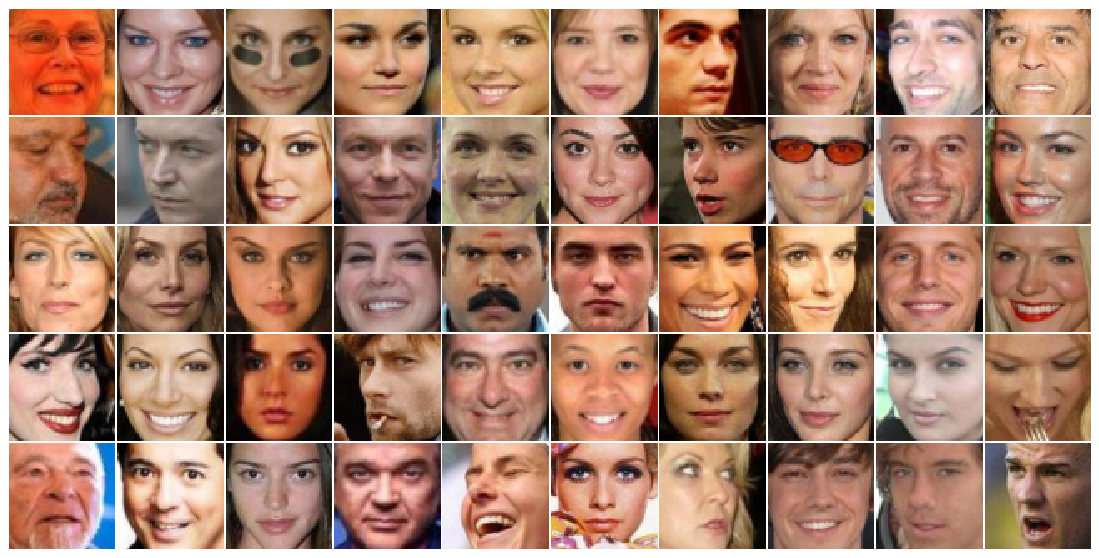

In [15]:
grid = denorm(make_grid(x[0:50,...], padding=1, pad_value=1, nrow=10).detach()).numpy()
plt.figure(figsize=(20, 10))
plt.imshow(grid.transpose(1, 2, 0))
plt.axis('off');

## CNN VAE Model

We are going to crete VAE very similar to the architecture shown bellow.

![title](https://ml-cheatsheet.readthedocs.io/en/latest/_images/vae.png)

### Weights initialization

helper function that initializes weights of Convolutional and Linear layers 
https://arxiv.org/abs/1502.01852

In [16]:
def init_weights(m: nn.Module):

    for m in m.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None: nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            if m.bias is not None: nn.init.constant_(m.bias, 0)

### Convolutional Block

function that creates a convolutional block followed by batch normalization and ReLU activation

In [17]:
def conv(nf: int, of: int, ks: int, stride: int = 1, use_act: bool = True, use_bn: bool = True):
    
    conv = nn.Conv2d(in_channels=nf, 
                     out_channels=of, 
                     kernel_size=ks, 
                     stride=stride, 
                     padding=ks // 2, 
                     bias=not use_bn)
    
    layers = [conv]
    
    if use_bn:
        layers.append(nn.BatchNorm2d(of))
    
    if use_act:
        layers.append(nn.ReLU(inplace=True))
    
    return nn.Sequential(*layers)

In [18]:
conv(3, 64, 3)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)

### CNN Encoder

In [19]:
class Encoder(nn.Module):
    def __init__(self, in_channels: int, nf: int):
        super().__init__()
        
        layers = []
        
        layers.append(conv(in_channels, nf, ks=3))
        layers.append(conv(nf, nf, ks=3))
        for i in range(3):
            layers.append(conv(nf, 2*nf, ks=3, stride=2))
            layers.append(conv(2*nf, 2*nf, ks=3, stride=1))
            nf *= 2
        
        self.encoder = nn.Sequential(*layers)
        
        init_weights(self)
        
    def forward(self, x): 
        return self.encoder(x)
    

In [20]:
Encoder(3, 32)

Encoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential

### Decoder

In decoder, we will be using nearest-neighbour upscaling followed by convolutional layer

In [21]:
class Decoder(nn.Module):
    
    def __init__(self, in_channels: int, nf: int):
        super().__init__()
        
        layers = []
        
        for i in range(3):
            layers.append(nn.UpsamplingNearest2d(scale_factor=2))
            layers.append(conv(nf, nf//2, ks=3, stride=1))
            nf //= 2
        
        layers.append(conv(nf, in_channels, ks=1, use_act=False, use_bn=False))
        
        self.decoder = nn.Sequential(*layers)
        
        init_weights(self)
    
    def forward(self, x): 
        return self.decoder(x)
    

In [22]:
Decoder(3, 256)

Decoder(
  (decoder): Sequential(
    (0): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
    (1): Sequential(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
    (3): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
    (5): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (6): Sequential(
      (0): Conv2d(32, 3, kernel_size=(1, 1), st

### CNN VAE

In [23]:
class ConvolutionalVAE(nn.Module):
    
    def __init__(self, z_dim: int):
        super().__init__()
        
        self.enc_out_shape = (256, 8, 8)
            
        self.encoder = Encoder(3, 32)
        self.decoder = Decoder(3, self.enc_out_shape[0])

        self.mu     = nn.Linear(np.prod(self.enc_out_shape), z_dim)
        self.logvar = nn.Linear(np.prod(self.enc_out_shape), z_dim)
        
        self.fc = nn.Linear(z_dim, np.prod(self.enc_out_shape))
        
        init_weights(self)
        
    def encode(self, x):
        
        enc = self.encoder(x).view(x.shape[0], -1)
        
        mu, logvar = self.mu(enc), self.logvar(enc)
        
        return mu, logvar
    
    def sample_z(self, mu, logvar):
        
        eps = torch.rand_like(mu)
        
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z):
        
        # tanh activation is used to squeeze output pixel values in [-1, 1] range similar to input.
        
        return torch.tanh(self.decoder(self.fc(z).view(-1, *self.enc_out_shape)))
        
    def forward(self, x):
        
        mu, logvar = self.encode(x)
        
        z = self.sample_z(mu, logvar)
        
        return self.decode(z)

In [24]:
o = ConvolutionalVAE(10)(x)
o.shape, o.mean(), o.std(), o.min(), o.max()

(torch.Size([64, 3, 64, 64]),
 tensor(0.0988, grad_fn=<MeanBackward0>),
 tensor(0.6553, grad_fn=<StdBackward0>),
 tensor(-1.0000, grad_fn=<MinBackward1>),
 tensor(1.0000, grad_fn=<MaxBackward1>))

### Training Loop

Below we build a training loop.  

Instead of L2 term in ELBO loss, we use L1 loss that produces not as blurry outputs as L2 does (recommended by Jeremy Howard from fast.ai). 

We use Adam optimizer with learning learning decay of factor 2 after every epoch.

In [25]:
def elbo_loss(inp, tar, mu, logvar, alpha: float = 1, beta: float = 1):
    
    recon_loss = nn.functional.l1_loss(inp, tar, reduction='none').sum(dim=(1, 2, 3))
            
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

    loss = torch.mean(alpha * kld_loss + beta * recon_loss)
    
    return loss, torch.mean(recon_loss), torch.mean(kld_loss)

In [26]:
def show_summary(valid_dl: DataLoader, model: DataLoader):
    
    N_SAMPLES = 15
    
    model.eval()
    
    actuals, preds = [], []
    with torch.no_grad():
        for i, x in enumerate(valid_dl.dataset):
            
            actuals.append(x)
            
            recon_x = model(x.unsqueeze(0).cuda()).cpu()
            
            preds.append(recon_x.squeeze(0))
            
            if i + 1 == N_SAMPLES:
                break
                
    model.train()
            
    grid = denorm(make_grid([*actuals, *preds], pad_value=1, padding=1, nrow=N_SAMPLES))

    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [27]:
def train_vae(train_dl: DataLoader, 
              valid_dl: DataLoader,
              model: nn.Module,
              n_epochs: int):
    
    LOG_INTERVAL = 20
    SUMMARY_INTERVAL = 100
    
    model = model.cuda()
    
    model.train()
    
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    sched = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.5, last_epoch=-1)
    
    acc_recon_loss, acc_kld_loss, acc_loss = 0, 0, 0
    
    i = 1
    for epoch in range(n_epochs):
        for x in train_dl:
            
            optim.zero_grad()
            
            x = x.cuda()

            mu, logvar = model.encode(x)
            
            z = model.sample_z(mu, logvar)
        
            x_recon = model.decode(z)
        
            loss, recon_loss, kld_loss = elbo_loss(x_recon, x, mu, logvar, alpha=1, beta=1)

            acc_recon_loss += recon_loss.item()
            acc_kld_loss += kld_loss.item()
            acc_loss += loss.item()
            
            loss.backward()
            
            optim.step()
            
            if (i + 1) % LOG_INTERVAL == 0:
                
                print('epoch %d | iter %d | loss %.5f | KL loss %.5f | recon loss %.5f' % 
                      (epoch + 1, 
                       i + 1, 
                       acc_loss / LOG_INTERVAL, 
                       acc_kld_loss / LOG_INTERVAL, 
                       acc_recon_loss / LOG_INTERVAL,
                       ))
                
                acc_recon_loss, acc_kld_loss, acc_loss = 0, 0, 0
                
            if (i + 1) % SUMMARY_INTERVAL == 0:
                show_summary(valid_dl, model)
                
            i += 1
            
        sched.step()

### Initialize vae

We will use 128 dimensional latent space for this task.

In [28]:
vae = ConvolutionalVAE(128)

As far as it takes a while until network starts producing good quality outputs, we will be using pre-trained weights for visualizations in this notebook.  
  
  
You can still uncomment and run the following cell for few iterations to see how output quality gradually increases as training proceedes. 

In [29]:
# train_vae(train_dl, valid_dl, vae, 50)

In [30]:
# torch.save(vae.state_dict(), 'cnn-vae')

### Transfer Learning & Perceptual Loss

There are bunch of tricks we could use to achieve better performance on our task. For instance we could experiment with other encoders (e.g. Resnet, EfficientNet), try other upsampling strategies rather than nearest-neighbour (e.g Transposed Convolution, Subpixcel Convolution, etc...)  
  
Here we will show one, rather non-intuitive, strategy that will reduce blurness of outputs and speed up convergence of our CNN VAE.  

This method is using third loss component - <b>Perceptual Loss</b> https://arxiv.org/abs/1603.08155  

The brief idea is to take frozen ImageNet pre-trained CNN model (here VGG16), do forward-pass on given training image as well as reconstruction produced by VAE, and enforce certain intermediate feature maps of both forward passed to be close together by L1/L2 losses.  

Intuition is that, we not only enforce image similarity in original pixel space (that is, MSE(input, reconstruction)), but also in intermediary feature spaces of VGG16.

defining perceptual loss using pretrained VGG16 architecture.
code partially taken from fast.ai deep learning course

In [31]:
class Hook:
    """Helper class to capture intermediary feature activations during forward-pass in VGG16."""

    def __init__(self, m): 
        
        self.feats = None
        
        self.hook = m.register_forward_hook(self._hook_fn)
    
    def _hook_fn(self, m, inp, out): 
        self.feats = out
        
    def remove(self): 
        self.hook.remove()        

In [32]:
class PerceptualLoss:
    """Perceptual Loss using VGG16 architecture."""
    
    def __init__(self):
        
        vgg16 = torchvision.models.vgg16_bn(pretrained=True)
        
        self.vgg16_head = nn.Sequential(*list(vgg16.children())[0]).cuda()
                
        # These are the indices of layers in VGG16 we are going to use in our loss. 
        feat_indices = [5, 15]
        
        # freezing the model. We only need static VGG16 used only for forward-pass.
        for p in self.vgg16_head.parameters():
            p.requires_grad = False
        
        # registering PyTorch hooks that will grab feature activations during forward pass.
        self.hooks = [Hook(self.vgg16_head[i]) for i in feat_indices]
        
    def __call__(self, x_recon, x):
        
        # forward-pass on reconstructed image.
        self.vgg16_head(x_recon)
        
        # saving extracted feature activations.
        x_recon_feats = [h.feats.clone() for h in self.hooks]
        
        # forward-pass on original input image.
        self.vgg16_head(x)
        
        # applying MSE loss on extracted features.
        loss = sum([torch.nn.functional.mse_loss(x_recon_feats[i], h.feats, reduction='sum') for i, h in enumerate(self.hooks)])
        
        return loss
            
    def close(self):
        for h in self.hooks: h.remove()

In [33]:
percept_loss = PerceptualLoss()
percept_loss.vgg16_head

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/ubuntu/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

### ELBO with Perceptual loss

We redefine our ELBO loss so that it now includes perceptual loss component as well

In [34]:
def elbo_loss(inp, tar, mu, logvar, alpha: float = 1, beta: float = 1, gamma: float = 1):
    
    recon_loss = nn.functional.l1_loss(inp, tar, reduction='none').sum(dim=(1, 2, 3))
            
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

    loss = torch.mean(alpha * kld_loss + beta * recon_loss + gamma * percept_loss(inp, tar))
    
    return loss, torch.mean(recon_loss), torch.mean(kld_loss)

### Train with perceptual loss

We can now train our VAE with Perceptual loss and see that it gives better results on early iterations as opposed to previous training.

In [35]:
vae_percept = ConvolutionalVAE(128)

epoch 1 | iter 20 | loss 958049.71562 | KL loss 124011.84399 | recon loss 6797.65891
epoch 1 | iter 40 | loss 781162.83750 | KL loss 6913.86083 | recon loss 6420.20576
epoch 1 | iter 60 | loss 714739.72188 | KL loss 1906.10709 | recon loss 5332.56797
epoch 1 | iter 80 | loss 639356.20312 | KL loss 2109.11151 | recon loss 4413.82737
epoch 1 | iter 100 | loss 567814.90000 | KL loss 2458.27860 | recon loss 3280.36876


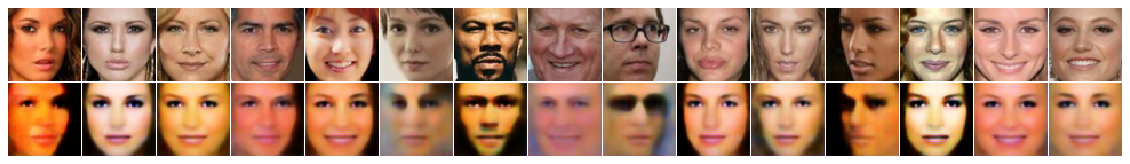

epoch 1 | iter 120 | loss 525316.32656 | KL loss 2655.67190 | recon loss 2817.14254
epoch 1 | iter 140 | loss 499419.47031 | KL loss 2662.23683 | recon loss 2568.59249
epoch 1 | iter 160 | loss 481805.22187 | KL loss 2796.38901 | recon loss 2381.39142
epoch 1 | iter 180 | loss 467456.34687 | KL loss 2904.03684 | recon loss 2264.48793
epoch 1 | iter 200 | loss 451386.33750 | KL loss 3055.30840 | recon loss 2160.97799


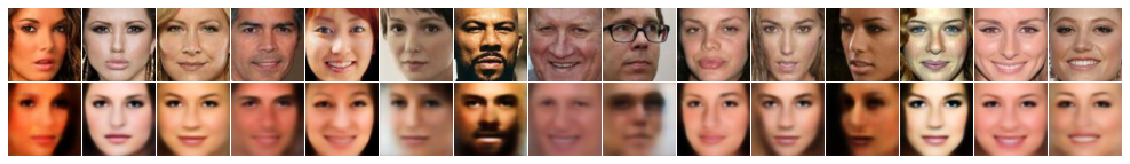

epoch 1 | iter 220 | loss 438057.34219 | KL loss 3033.78138 | recon loss 2070.27809
epoch 1 | iter 240 | loss 428513.80938 | KL loss 3051.43402 | recon loss 2002.60334
epoch 1 | iter 260 | loss 425081.51250 | KL loss 3124.25172 | recon loss 1976.78873
epoch 1 | iter 280 | loss 412885.85156 | KL loss 3115.58195 | recon loss 1903.94860
epoch 1 | iter 300 | loss 407110.20469 | KL loss 3181.40217 | recon loss 1830.61021


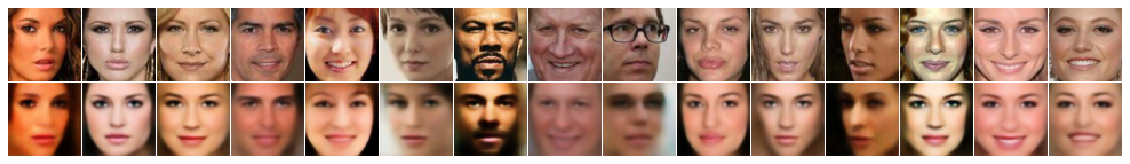

epoch 1 | iter 320 | loss 398559.91250 | KL loss 3318.87067 | recon loss 1790.71261
epoch 1 | iter 340 | loss 393473.17031 | KL loss 3377.17214 | recon loss 1783.40372
epoch 1 | iter 360 | loss 390729.68750 | KL loss 3399.81348 | recon loss 1763.43942
epoch 1 | iter 380 | loss 382192.27187 | KL loss 3463.99958 | recon loss 1670.78530
epoch 1 | iter 400 | loss 380945.67500 | KL loss 3512.37906 | recon loss 1684.11796


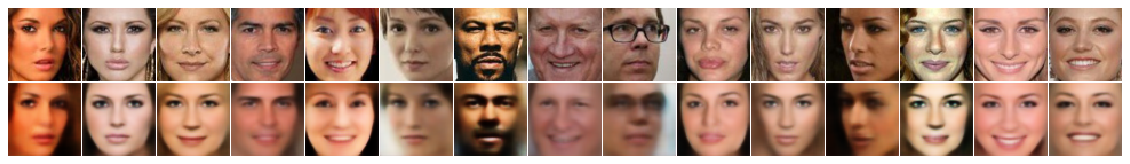

epoch 1 | iter 420 | loss 375461.42812 | KL loss 3565.34949 | recon loss 1661.12557
epoch 1 | iter 440 | loss 365033.49844 | KL loss 3598.97185 | recon loss 1601.48562
epoch 1 | iter 460 | loss 366689.87344 | KL loss 3692.84938 | recon loss 1591.70458
epoch 1 | iter 480 | loss 356849.29063 | KL loss 3641.08865 | recon loss 1550.28398
epoch 1 | iter 500 | loss 359311.09219 | KL loss 3683.20831 | recon loss 1555.12385


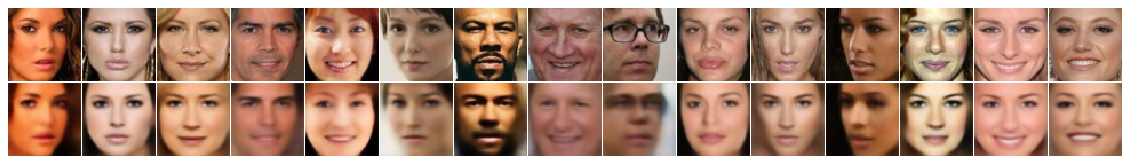

epoch 1 | iter 520 | loss 357218.87969 | KL loss 3699.37190 | recon loss 1568.87957
epoch 1 | iter 540 | loss 352150.85938 | KL loss 3796.81768 | recon loss 1528.22175
epoch 1 | iter 560 | loss 357983.63281 | KL loss 3895.63901 | recon loss 1530.78682
epoch 1 | iter 580 | loss 350061.03750 | KL loss 3836.90013 | recon loss 1529.91516
epoch 1 | iter 600 | loss 345351.73750 | KL loss 3937.07345 | recon loss 1503.19592


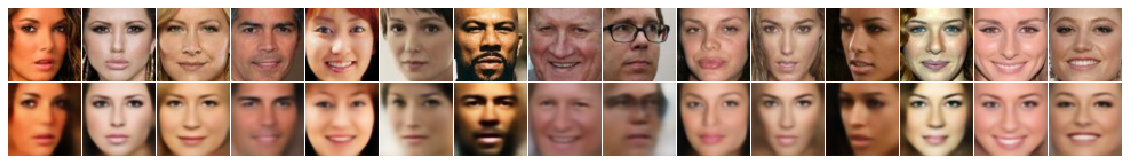

epoch 1 | iter 620 | loss 341662.25469 | KL loss 4051.45542 | recon loss 1443.95325
epoch 1 | iter 640 | loss 339203.90156 | KL loss 4095.56016 | recon loss 1448.12117
epoch 1 | iter 660 | loss 336563.52187 | KL loss 4138.28674 | recon loss 1428.21491
epoch 1 | iter 680 | loss 337491.32188 | KL loss 4105.19240 | recon loss 1461.57365
epoch 1 | iter 700 | loss 333193.56250 | KL loss 4118.99858 | recon loss 1435.06641


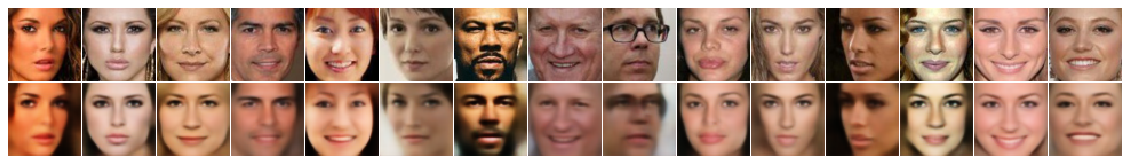

epoch 1 | iter 720 | loss 330635.54063 | KL loss 4213.12087 | recon loss 1402.49904
epoch 1 | iter 740 | loss 325416.29219 | KL loss 4343.05002 | recon loss 1376.35892
epoch 1 | iter 760 | loss 327564.08906 | KL loss 4471.95293 | recon loss 1372.10932
epoch 1 | iter 780 | loss 328010.66094 | KL loss 4461.72666 | recon loss 1412.76185
epoch 1 | iter 800 | loss 326650.26406 | KL loss 4012.08221 | recon loss 1435.47867


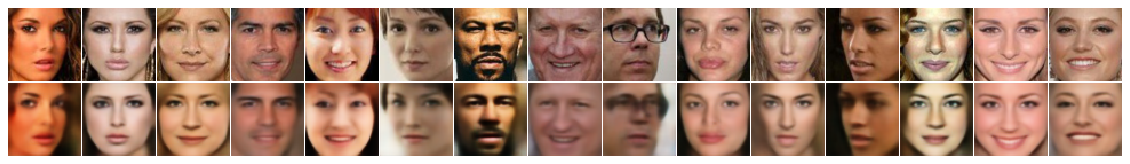

epoch 1 | iter 820 | loss 322404.45000 | KL loss 4059.61317 | recon loss 1390.14151
epoch 1 | iter 840 | loss 324380.96563 | KL loss 4184.06805 | recon loss 1378.74406
epoch 1 | iter 860 | loss 321338.83594 | KL loss 4327.98540 | recon loss 1334.02411
epoch 1 | iter 880 | loss 320372.85469 | KL loss 4352.81465 | recon loss 1382.33685
epoch 1 | iter 900 | loss 314893.63906 | KL loss 4444.25300 | recon loss 1334.29533


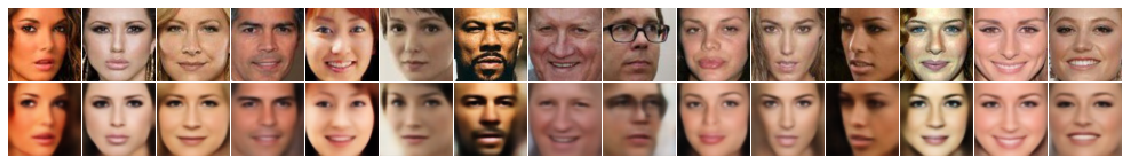

epoch 1 | iter 920 | loss 313304.97969 | KL loss 4584.15051 | recon loss 1312.99226
epoch 1 | iter 940 | loss 315972.09531 | KL loss 4522.09019 | recon loss 1352.30704
epoch 1 | iter 960 | loss 314551.86406 | KL loss 4397.41758 | recon loss 1342.44506
epoch 1 | iter 980 | loss 310072.72344 | KL loss 4510.69934 | recon loss 1299.26446
epoch 1 | iter 1000 | loss 308821.62969 | KL loss 4610.71069 | recon loss 1304.86699


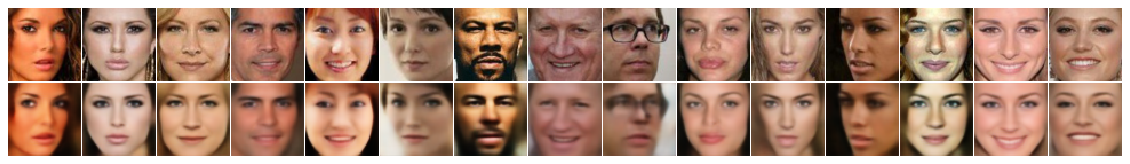

epoch 1 | iter 1020 | loss 304884.42188 | KL loss 4726.49417 | recon loss 1305.18779
epoch 1 | iter 1040 | loss 308254.68750 | KL loss 4708.47483 | recon loss 1284.37617
epoch 1 | iter 1060 | loss 306249.92656 | KL loss 4802.33953 | recon loss 1275.46418
epoch 1 | iter 1080 | loss 304211.67031 | KL loss 4792.92258 | recon loss 1281.45375


KeyboardInterrupt: 

In [36]:
train_vae(train_dl, valid_dl, vae_percept, 50)

## Experiments with Visual Arithmetic in Latent Space

Similar to word2vec, we can do some pretty interesting visual experiments by performing arithmetics in latent space.

For example, we can manipulate certain facial attributes (e.g. wearing sunglasses, having a smile, long hair, etc...) on a picture by simply adding/subtracting the some vectors.

Below we will show how to paint sunglasses and smile on an arbitrary image.

### Download Pre-Trained CNN VAE

In [38]:
if not os.path.exists('cnn-vae-5-l1.model'):
    !wget https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/workshop-amld2020/cnn-vae-5-l1.model

### Load Pre-Trained CNN VAE

In [39]:
vae.load_state_dict(torch.load('cnn-vae-5-l1.model'))
vae.eval();

### Get Mean Vectors per feature attribute

This function selects 250 images having a certain characteristic (e.g Glasses, Long Hair, etc...) and averages their latent vectors in order to get a vector encoding this characteristic.

In [41]:
def get_mean_vec(vae: nn.Module, df: pd.DataFrame, condition):

    vae.cpu()
    
    images = []
    for i, im_id in enumerate(df[condition].image_id.values):
        images.append(valid_dl.dataset.get_by_id(im_id))
        if i >= 250:
            break
        
    images = torch.stack(images)
    
    mu, logvar = vae.encode(images)
        
    return torch.mean(vae.sample_z(mu, logvar), dim=0, keepdim=True)

### Eyeglasses

#### computing mean vectors of "wearing glasses" and "not wearing glasses"

In [42]:
glasses1 = get_mean_vec(vae, df_attr, (df_attr.Eyeglasses == 1))
glasses0 = get_mean_vec(vae, df_attr, (df_attr.Eyeglasses == -1))

#### visualizing average face with glasses

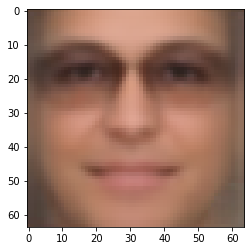

In [43]:
im = denorm(vae.decode(glasses1).detach())[0].numpy()
plt.imshow(im.transpose(1,2,0))

#### visualizing average face without glasses

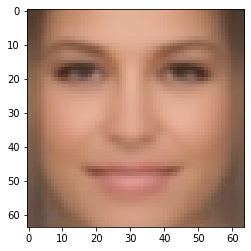

In [44]:
im = denorm(vae.decode(glasses0).detach())[0].numpy()
plt.imshow(im.transpose(1,2,0))

#### Visualizing the Vector("wearing glasses") - Vector("not wearing glasses") that gives vector encoding glass information.

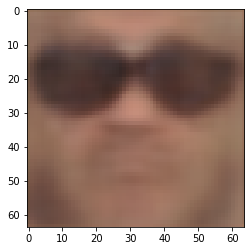

In [45]:
im = denorm(vae.decode(glasses1 - glasses0).detach())[0].numpy()
plt.imshow(im.transpose(1,2,0))

#### Add glasses to faces without glasses

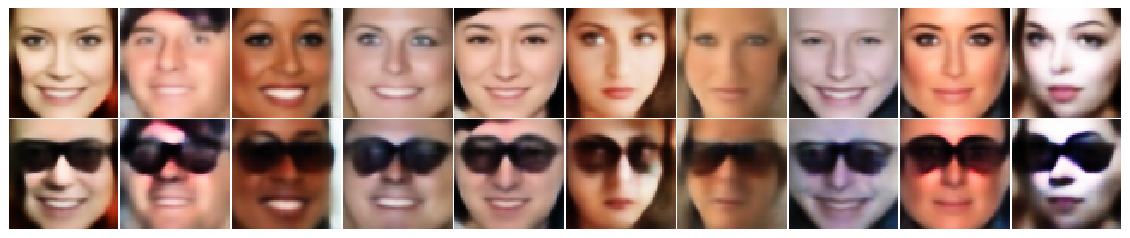

In [47]:
images = []
for i, im_id in enumerate(df_attr[df_attr.Eyeglasses == -1].tail(10).image_id.values):
    images.append(valid_dl.dataset.get_by_id(im_id))
images = torch.stack(images)

mu, logvar = vae.encode(images)

z1 = vae.sample_z(mu, logvar)
z2 = vae.sample_z(mu + 2.5*(glasses1 - glasses0), logvar)

images = torch.cat([vae.decode(z1), vae.decode(z2)])

grid = denorm(make_grid(images, padding=1, pad_value=1, nrow=10).detach()).numpy()
plt.figure(figsize=(20, 10))
plt.imshow(grid.transpose(1, 2, 0))
plt.axis('off');

### Smile

### we can do the same experiment with "smile vector"

In [48]:
smile1 = get_mean_vec(vae, df_attr, (df_attr.Smiling == 1))
smile0 = get_mean_vec(vae, df_attr, (df_attr.Smiling == -1))

#### Show average smiling face

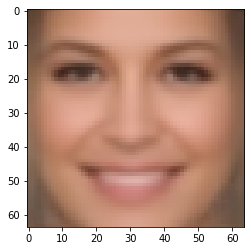

In [49]:
im = denorm(vae.decode(smile1).detach())[0].numpy()
plt.imshow(im.transpose(1,2,0))

#### Show average non-smiling face

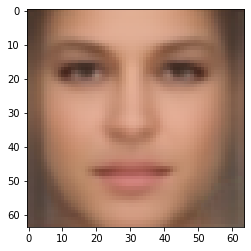

In [50]:
im = denorm(vae.decode(smile0).detach())[0].numpy()
plt.imshow(im.transpose(1,2,0))

#### Add smile feature to images

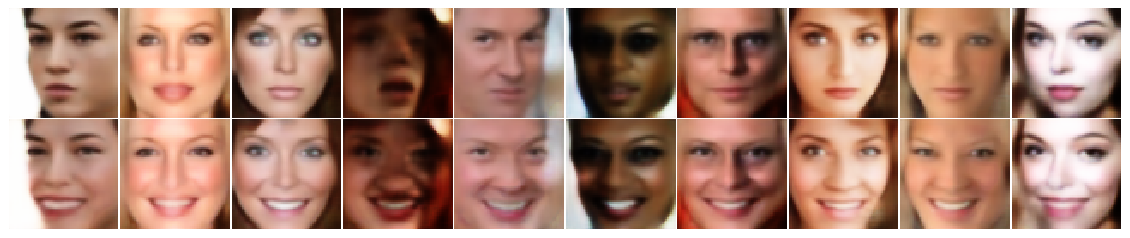

In [51]:
images = []
for i, im_id in enumerate(df_attr[df_attr.Smiling == -1].tail(10).image_id.values):
    images.append(valid_dl.dataset.get_by_id(im_id))
images = torch.stack(images)

mu, logvar = vae.encode(images)

z1 = vae.sample_z(mu, logvar)
z2 = vae.sample_z(mu + 2*(smile1 - smile0), logvar)

images = torch.cat([vae.decode(z1), vae.decode(z2)])

grid = denorm(make_grid(images, padding=1, pad_value=1, nrow=10).detach()).numpy()
plt.figure(figsize=(20, 10))
plt.imshow(grid.transpose(1, 2, 0))
plt.axis('off');

### 2D manifold with face attributes (features) basis

Now we will visualize the 2D manifold where axes encode "Smile" and "Wearing Sunglasses"

In [52]:
# mean Z vector of no smile and with eyeglasses
z_smile0_glass1 = get_mean_vec(vae, df_attr, (df_attr.Eyeglasses == 1) & (df_attr.Smiling == -1))

# mean Z vector of smile and with no eyeglasses
z_smile1_glass0 = get_mean_vec(vae, df_attr, (df_attr.Eyeglasses == -1) & (df_attr.Smiling == 1))

# mean Z vector of no smile and with no eyeglasses
z_glass0_smile0 = get_mean_vec(vae, df_attr, (df_attr.Eyeglasses == -1) & (df_attr.Smiling == -1))

### Show 2D manifold

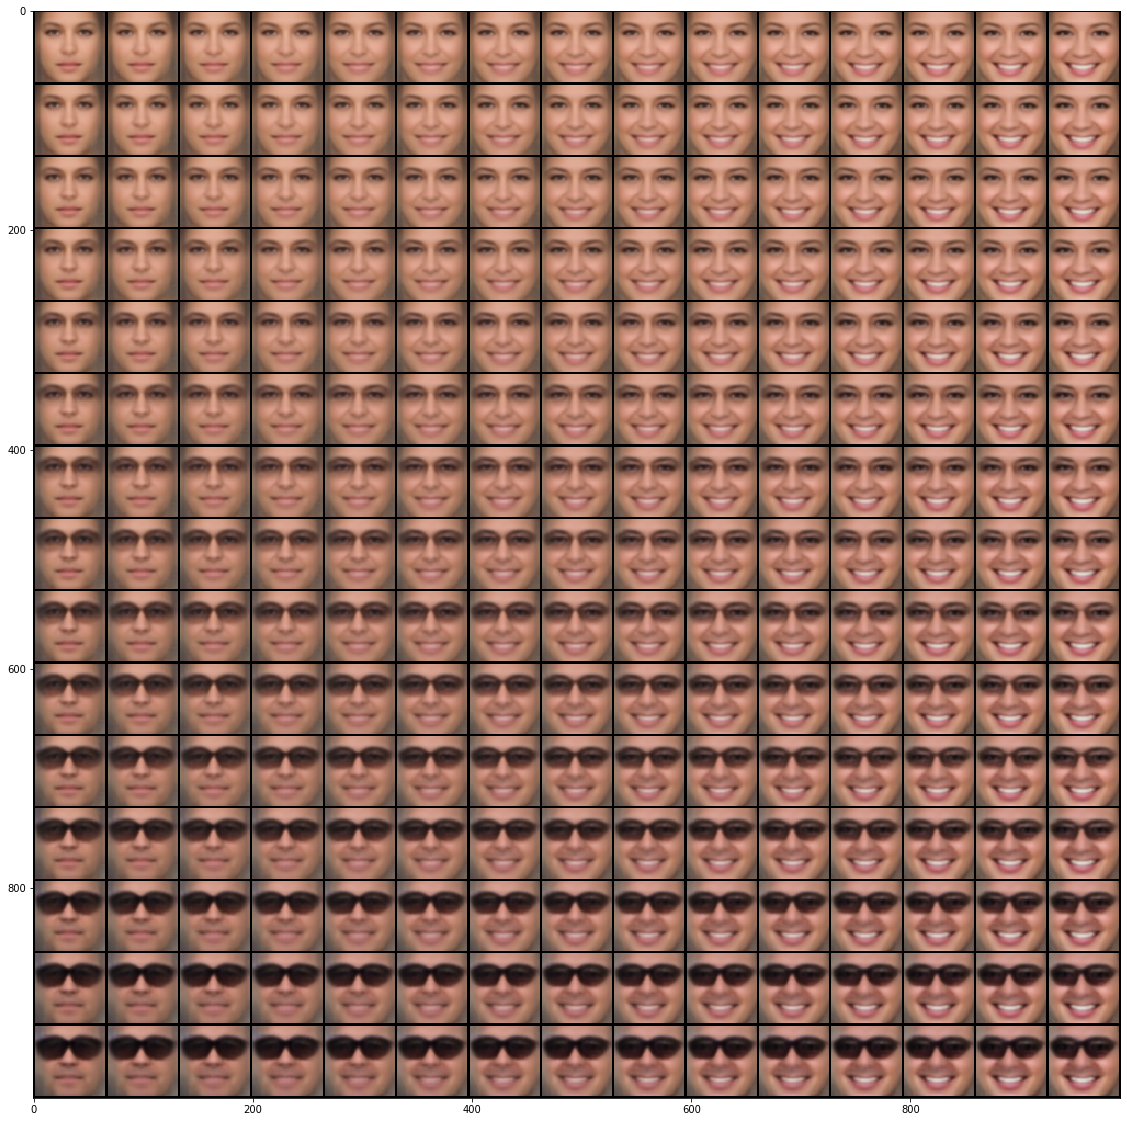

In [53]:
line = np.linspace(0, 2, 15)

# definining 2D basis vectors
I, J = z_smile0_glass1 - z_glass0_smile0, z_smile1_glass0 - z_glass0_smile0

res = []
for a in line:
    for b in line:
        z = z_glass0_smile0 + a * I + b * J
        x_recon = denorm(vae.decode(z))
        res.append(x_recon)
        
# displaying space

grd = make_grid(torch.cat(res, dim=0), 15).detach().numpy()
plt.figure(figsize=(20, 20))
plt.imshow(grd.transpose(1, 2, 0))

## Summary

As we see latent space generated by VAE model has nice features. You can implement simple arithmetic on feature vectors as we did there. Since latent space is continuous we are getting smooth transitions between features in feature space.

You can apply VAE in different domain like: text, audio, etc. 

VAE's are also used to understand inner structure of data, augment data, de-noise etc. With little modifications and extensions of VAE you can do pretty interesting stuff. See more overview of variety of VAE models [here](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#sparse-autoencoder).
also see [blog 1](https://news.sophos.com/en-us/2018/06/15/using-variational-autoencoders-to-learn-variations-in-data/)  and [blog 2](https://www.jeremyjordan.me/variational-autoencoders/)